In [1]:
!git clone https://github.com/otakbeku/nlpstei.git

Cloning into 'nlpstei'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 22 (delta 10), reused 21 (delta 9), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
import nltk
import random
import pandas as pd
import requests
import heapq 

from nltk.tokenize import wordpunct_tokenize, blankline_tokenize
import spacy

from itertools import combinations
from nltk.corpus import stopwords
from time import time 
from gensim.models import Word2Vec
import multiprocessing

from collections import namedtuple
from sklearn import preprocessing


# Pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

import pprint
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='239480140419')

In [4]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [5]:
pp = pprint.PrettyPrinter(indent=4)
RANDOM_SEED = 101

In [6]:

lyrics = pd.read_csv('./nlpstei/models/lyrics_song_genres_15k.csv')
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artist         15000 non-null  object
 1   song_name      15000 non-null  object
 2   closest_genre  15000 non-null  object
 3   lyric          15000 non-null  object
 4   length_lyric   15000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 586.1+ KB


In [7]:
lyrics.describe()

,length_lyric
count,15000.000000
mean,228.412333
std,127.623821
min,4.000000
25%,149.000000
50%,204.000000
75%,272.000000
max,2634.000000


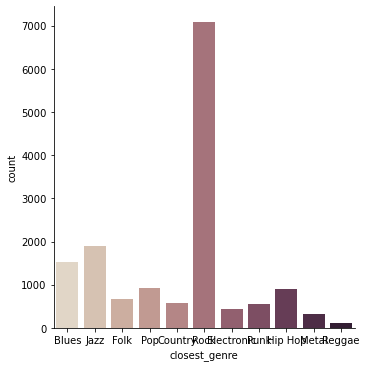

In [8]:
sns.catplot(x="closest_genre", kind="count", palette="ch:.25", data=lyrics)

In [9]:
lyrics.groupby('closest_genre')['song_name'].nunique().sort_values()

closest_genre
Reggae         102
Metal          283
Electronic     398
Country        506
Punk           519
Folk           619
Pop            824
Hip Hop        841
Blues         1326
Jazz          1423
Rock          6306
Name: song_name, dtype: int64

In [10]:
lyrics.groupby('closest_genre')['length_lyric'].max().sort_values()

closest_genre
Electronic     600
Reggae         722
Punk           724
Metal          809
Blues          845
Jazz           857
Country        923
Pop           1003
Rock          1451
Hip Hop       1543
Folk          2634
Name: length_lyric, dtype: int64

In [11]:
lyrics.groupby('closest_genre')['length_lyric'].min().sort_values()

closest_genre
Blues          4
Jazz           4
Electronic     5
Hip Hop        6
Punk           6
Rock           6
Pop            7
Folk          25
Metal         33
Country       57
Reggae        71
Name: length_lyric, dtype: int64

In [12]:
lyrics.groupby('closest_genre')['length_lyric'].describe()

,count,mean,std,min,25%,50%,75%,max
closest_genre,,,,,,,,
Blues,1524.0,224.795276,109.517494,4.0,154.0,204.0,271.0,845.0
Country,578.0,225.060554,104.462633,57.0,160.0,203.0,264.0,923.0
Electronic,434.0,234.119816,92.921256,5.0,165.5,226.5,286.0,600.0
Folk,675.0,233.680000,156.363937,25.0,157.0,206.0,268.5,2634.0
Hip Hop,891.0,440.120090,231.989433,6.0,252.0,417.0,611.0,1543.0
Jazz,1900.0,174.035263,91.202391,4.0,114.0,152.0,214.0,857.0
Metal,313.0,208.738019,93.930220,33.0,147.0,195.0,245.0,809.0
Pop,926.0,256.767819,119.436031,7.0,178.0,233.5,313.0,1003.0
Punk,548.0,219.016423,103.923232,6.0,144.0,205.0,273.0,724.0


Blues              AxesSubplot(0.1,0.736957;0.235294x0.163043)
Country       AxesSubplot(0.382353,0.736957;0.235294x0.163043)
Electronic    AxesSubplot(0.664706,0.736957;0.235294x0.163043)
Folk               AxesSubplot(0.1,0.541304;0.235294x0.163043)
Hip Hop       AxesSubplot(0.382353,0.541304;0.235294x0.163043)
Jazz          AxesSubplot(0.664706,0.541304;0.235294x0.163043)
Metal              AxesSubplot(0.1,0.345652;0.235294x0.163043)
Pop           AxesSubplot(0.382353,0.345652;0.235294x0.163043)
Punk          AxesSubplot(0.664706,0.345652;0.235294x0.163043)
Reggae                 AxesSubplot(0.1,0.15;0.235294x0.163043)
Rock              AxesSubplot(0.382353,0.15;0.235294x0.163043)
dtype: object

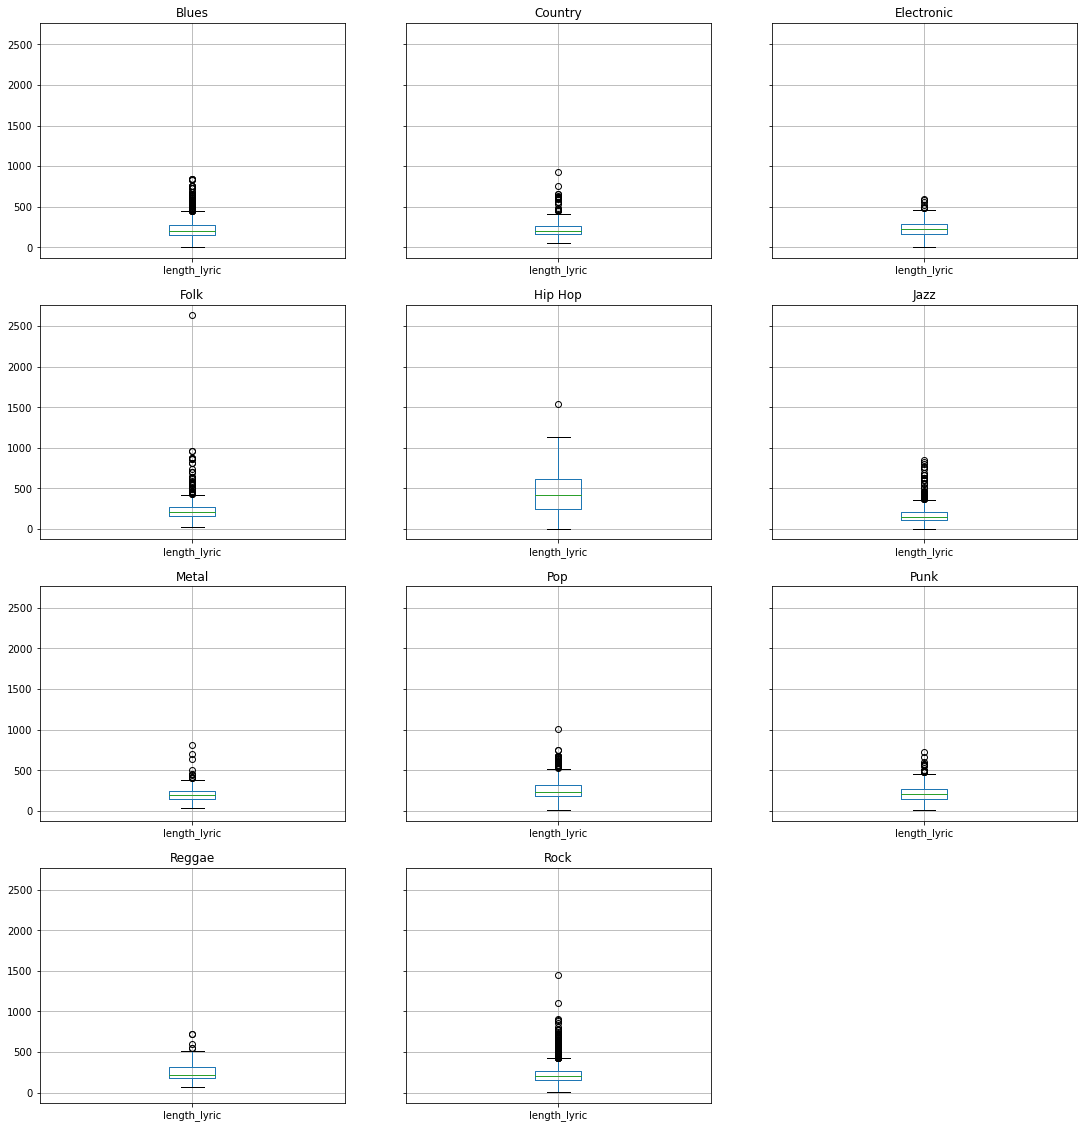

In [13]:
lyrics.groupby('closest_genre').boxplot(figsize=(18,20))

In [14]:
min_sentence_length = lyrics.lyric.apply(lambda x: x.split()).apply(len).min()
min_sentence_length

4

In [15]:
max_sentence_length = lyrics.lyric.apply(lambda x: x.split()).apply(len).max()
max_sentence_length

2634

In [16]:
lyrics_length_threshold = lyrics.lyric.apply(lambda x: x.split()).apply(len).quantile(0.25)
lyrics_length_threshold

149.0

In [17]:
cleaned_lyrics = lyrics[(lyrics.length_lyric>=lyrics_length_threshold)]
threshold = cleaned_lyrics.groupby('closest_genre')['song_name'].nunique()['Metal']
cleaned_lyrics = cleaned_lyrics[cleaned_lyrics.closest_genre!='Reggae']
cleaned_lyrics = cleaned_lyrics.groupby('closest_genre').sample(n=threshold, random_state=RANDOM_SEED)

In [18]:
cleaned_lyrics.groupby('closest_genre')['song_name'].nunique().sort_values()

closest_genre
Metal         193
Country       195
Electronic    196
Jazz          196
Folk          198
Blues         199
Pop           200
Hip Hop       204
Punk          204
Rock          207
Name: song_name, dtype: int64

In [19]:
cleaned_lyrics.groupby('closest_genre')['song_name'].nunique()

closest_genre
Blues         199
Country       195
Electronic    196
Folk          198
Hip Hop       204
Jazz          196
Metal         193
Pop           200
Punk          204
Rock          207
Name: song_name, dtype: int64

In [20]:
cleaned_lyrics.groupby('closest_genre')['song_name'].sum()

closest_genre
Blues         Tears Dry On Their OwnPsychedelic ShackI'm You...
Country       I Want Your Love - 2018 RemasterNext in LineMe...
Electronic    Cool Cat - Remastered 2011Cool CatBohemian Rha...
Folk          All My TrialsCopperhead RoadDeath Letter Blues...
Hip Hop       Rebirth Of Slick (Cool Like Dat)RosesLoserNo T...
Jazz          Recipe For LoveThese Boots Are Made For Walkin...
Metal         Narcosynthesis - live at the Zeche Bochum, Ger...
Pop           Whenever, WhereverI've Got the Music in MeLet ...
Punk          Vampires Will Never Hurt YouPersonality Crisis...
Rock          She Will Be Loved - Radio MixDaisy JaneAshes t...
Name: song_name, dtype: object

In [21]:
length_of_lyrics_per_genre = {}
for i, a in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    length_of_lyrics_per_genre[i] = len(a)

In [22]:
length_of_lyrics_per_genre

{'Blues': 262897,
 'Country': 256713,
 'Electronic': 265913,
 'Folk': 279209,
 'Hip Hop': 498608,
 'Jazz': 244479,
 'Metal': 264776,
 'Pop': 289343,
 'Punk': 273657,
 'Rock': 250262}

<BarContainer object of 10 artists>

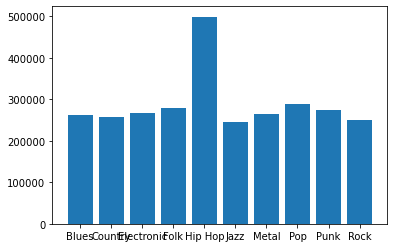

In [23]:
plt.bar(length_of_lyrics_per_genre.keys(), length_of_lyrics_per_genre.values())

In [24]:
unique_words_per_genre = {}
length_unique_words_per_genre = {}
for genre, lyric in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    text = lyric.lower()
    tokens = wordpunct_tokenize(text)
    unique_words_per_genre[genre] = set(tokens)
    length_unique_words_per_genre[genre] = len(set(tokens))

<BarContainer object of 10 artists>

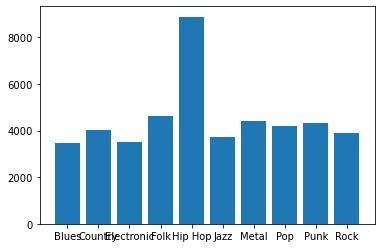

In [25]:
plt.bar(length_unique_words_per_genre.keys(), length_unique_words_per_genre.values())

In [26]:
w2v_model = Word2Vec.load("./nlpstei/models/fifteenKlyricswv_withstopwords.model")

In [27]:
embedding_matrix = torch.FloatTensor(w2v_model.wv.vectors)
embedding_matrix.shape

torch.Size([17678, 300])

In [28]:
word2idx = {}
for word in w2v_model.wv.index2word:
    word2idx[word] = w2v_model.wv.vocab[word].index

In [29]:
label_encoder = preprocessing.LabelEncoder()
Xs = cleaned_lyrics['lyric']
y = label_encoder.fit_transform(cleaned_lyrics['closest_genre']) 

In [30]:
def sentence_encoder(text, vocab2index):
    tokens = text.lower().split()
    # Unknown = 9999
    # Padding = 9998
    temp = np.full(len(vocab2index), vocab2index['paddingkosong'])
    sentencoded = np.array([vocab2index.get(word, vocab2index['tidakdiketahui']) for word in tokens])
    length = len(sentencoded)
    temp[:length] = sentencoded
    return temp

In [31]:

X = Xs.apply(lambda x: sentence_encoder(x, word2idx))
X = X.to_numpy()

In [32]:
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [33]:
classes = cleaned_lyrics.closest_genre.unique()
pp.pprint(classes)

array(['Blues', 'Country', 'Electronic', 'Folk', 'Hip Hop', 'Jazz',
       'Metal', 'Pop', 'Punk', 'Rock'], dtype=object)


In [34]:
train_on_gpu = torch.cuda.is_available()
lstm_dict = {
    'batch_size':8,
    'hidden_dim': embedding_matrix.shape[1],
    'lstm_layers':3,
    'input_size':embedding_matrix.shape[0],
    'padding_idx': w2v_model.wv.vocab['paddingkosong'].index,
}
lstm_args = namedtuple('lstm_args', lstm_dict.keys())(**lstm_dict)

In [35]:

# Simple LSTM Model
# Input size = vocab size = num_embeddings
# hidden dim = embedding_dim = 
class Simple_LSTM(nn.Module):
	def __init__(self, args):
		super(Simple_LSTM, self).__init__()
		
		# Hyperparameters
		self.batch_size = args.batch_size
		self.hidden_dim = args.hidden_dim
		self.LSTM_layers = args.lstm_layers
		self.input_size = args.input_size
		
		self.dropout = nn.Dropout(0.5)
		# self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
		self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=args.padding_idx, freeze=True)
		self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
		self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim*2)
		self.fc2 = nn.Linear(self.hidden_dim*2, 10)
		
	def forward(self, x):
		
		# Hidden and cell state definion
		h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).cuda()
		c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).cuda()
		
		# Initialization fo hidden and cell states
		torch.nn.init.xavier_normal_(h)
		torch.nn.init.xavier_normal_(c)

		# Each sequence "x" is passed through an embedding layer
		out = self.embedding(x)
		# Feed LSTMs
		out, (hidden, cell) = self.lstm(out, (h,c))
		out = self.dropout(out)
		# The last hidden state is taken
		out = torch.relu_(self.fc1(out[:,-1,:]))
		out = self.dropout(out)
		out = torch.sigmoid(self.fc2(out))

		return out

In [36]:
class DatasetMaper(Dataset):
	'''
	Handles batches of dataset
	'''
  
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

training_set = DatasetMaper(X_train, y_train)
validation_set = DatasetMaper(X_val, y_val)
test_set = DatasetMaper(X_test, y_test)
		
loader_training = DataLoader(training_set, batch_size=lstm_args.batch_size)
loader_val = DataLoader(training_set, batch_size=lstm_args.batch_size)
loader_test = DataLoader(test_set)

In [37]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [38]:
WARMUP_STEPS=500
WARMUP_FACTOR = 1.0 / 3.0
GLOBAL_STEPS=0
LR_INIT=0.01
def train_model(model, train_dl,val_dl, epochs=10, lr=0.01):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.SGD(model.parameters(),lr =lr,momentum=0.9,weight_decay=0.0001)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            x = torch.tensor(x).to(torch.long).cuda()
            y = y.cuda()
            y_pred = model(x)
            optimizer.zero_grad()
#             print(type(y_pred))
#             print(y_pred)
#             print(y)
            loss = F.cross_entropy(y_pred, y)

            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc = validation_metrics(model, val_dl)
        torch.cuda.empty_cache()
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))

In [39]:
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y in valid_dl:
        x = x.cuda()
        y = y.cuda()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    torch.cuda.empty_cache()
    return sum_loss/total, correct/total

In [40]:
model = Simple_LSTM(lstm_args).cuda()

In [41]:
train_model(model, loader_training,loader_val, epochs=10, lr=0.01)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


train loss 2.303, val loss 2.302, val accuracy 0.105
train loss 2.302, val loss 2.302, val accuracy 0.106


In [42]:
torch.cuda.empty_cache()

In [43]:
len(classes)

10

In [46]:
bucket = storage_client.bucket('song_lyrics')
torch.save(model.state_dict(),"../working/model_lyrics_{}_best.pth".format(10))
blob = bucket.blob("model_lyrics_{}_best.pth".format(10))
blob.upload_from_filename("../working/model_lyrics_{}_best.pth".format(10))

In [1]:
val_loss, val_acc = validation_metrics(model, loader_val)
print("val loss %.3f, val accuracy %.3f" % (val_loss, val_acc))

In [ ]:
test_loss, test_acc = validation_metrics(model, loader_test)
print("test loss %.3f, test accuracy %.3f" % (test_loss, test_acc))

In [44]:
# epochs=10
# lr=0.01
# parameters = filter(lambda p: p.requires_grad, model.parameters())
# optimizer = torch.optim.SGD(model.parameters(),lr =lr,momentum=0.9,weight_decay=0.0001)
# for i in range(epochs):
#     model.train()
#     sum_loss = 0.0
#     total = 0
#     for x, label in loader_training:
#         x = torch.tensor(x).to(torch.long).cuda()
#         label = label.cuda()
#         y_pred = model(x)
#         optimizer.zero_grad()
# #         print(type(y_pred))
# #         print(y_pred)
# #         print(label)
#         loss = F.cross_entropy(y_pred, label)

#         loss.backward()
#         optimizer.step()
#         sum_loss += loss.item()*label.shape[0]
#         total += label.shape[0]
# #     val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
#     torch.cuda.empty_cache()
#     if i % 5 == 1:
#         print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

In [45]:
label.shape

NameError: name 'label' is not defined

In [ ]:
y_pred.shape